In [1]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import requests
import json

In [2]:
#load in csv
olympics_data = pd.read_csv("Summer-Olympic-medals-1976-to-2008.csv", encoding="latin-1")
olympics_data.head()

,City,Year,Sport,Discipline,Event,Athlete,Gender,Country_Code,Country,Event_gender,Medal
0,Montreal,1976.0,Aquatics,Diving,3m springboard,"KÖHLER, Christa",Women,GDR,East Germany,W,Silver
1,Montreal,1976.0,Aquatics,Diving,3m springboard,"KOSENKOV, Aleksandr",Men,URS,Soviet Union,M,Bronze
2,Montreal,1976.0,Aquatics,Diving,3m springboard,"BOGGS, Philip George",Men,USA,United States,M,Gold
3,Montreal,1976.0,Aquatics,Diving,3m springboard,"CAGNOTTO, Giorgio Franco",Men,ITA,Italy,M,Silver
4,Montreal,1976.0,Aquatics,Diving,10m platform,"WILSON, Deborah Keplar",Women,USA,United States,W,Bronze


In [3]:
# Assign Medal Counts
medal_dict = {'Gold':3,'Silver':2,'Bronze':1}
olympics_data['Points'] = olympics_data['Medal'].map(medal_dict)

In [4]:
# Load in Host Country CSV, merge with Olympics Data Frame
host_country_df = pd.read_csv('Host_Countries.csv')
host_country_df = host_country_df[['Year','Country']]
host_country_df.rename(columns={'Country':'Host Country'},inplace=True)
olympics_data = olympics_data.merge(host_country_df,on='Year')

In [5]:
# Get pt Total DF by year
pt_total_df = olympics_data.groupby('Year').sum()

In [6]:
# Find Host Years and Host City, Country

host_years = olympics_data['Year'].unique()

year_countries_dict = {}
for i in host_years:
    if i == 1988.0:
        year_countries_dict[i] = 'Korea, South'
    elif i == 1980.0:
        year_countries_dict[i] = 'Soviet Union'
    else:
        year_countries_dict[i] = olympics_data[olympics_data['Year']==i]['Host Country'].unique()[0]
        
# Create DF with only host countries

host_countries = []
for k,v in year_countries_dict.items():
    host_countries.append(v)

host_df = olympics_data[olympics_data['Country'].isin(host_countries)]

# Build Data Frame with a Year index and Host Country Point Totals as Columns

frame = pd.DataFrame(index=host_years)

for year in host_years:
    country = year_countries_dict[year]

    to_add = host_df[host_df['Country']==country].groupby('Year').sum()
    to_add.rename(columns={'Points':country},level=0,inplace=True)
    frame = frame.merge(to_add,how='outer',left_index=True,right_index=True)

frame.rename(columns={'United States_x':'United States'},inplace=True)
frame = frame[['Canada','Soviet Union','United States','Korea, South','Spain','Australia','Greece','China']]
frame

,Canada,Soviet Union,United States,"Korea, South",Spain,Australia,Greece,China
1976.0,28.0,604.0,337.0,20.0,12.0,40.0,NaN,NaN
1980.0,NaN,953.0,NaN,NaN,47.0,24.0,7.0,NaN
1984.0,159.0,NaN,784.0,83.0,37.0,78.0,3.0,141.0
1988.0,34.0,627.0,411.0,170.0,9.0,76.0,1.0,81.0
1992.0,103.0,NaN,452.0,110.0,174.0,112.0,6.0,165.0
1996.0,98.0,NaN,628.0,135.0,136.0,212.0,20.0,222.0
2000.0,43.0,NaN,574.0,123.0,69.0,372.0,32.0,180.0
2004.0,33.0,NaN,571.0,108.0,50.0,333.0,65.0,225.0
2008.0,69.0,NaN,674.0,171.0,133.0,253.0,10.0,385.0


In [7]:
# Add Point Total COlumn
frame_pt = frame.merge(pt_total_df,left_index=True,right_index=True)

In [8]:
host_country_df['City'] = olympics_data['City'].unique()
host_country_df['Search'] = host_country_df['City']+', '+host_country_df['Host Country']

In [9]:
# Get Lat and Long

from config import g_key

city_dict = {}

search_items = []
for i in host_country_df['Search'].values:
    search_items.append(i)

# Build URL using the Google Maps API
base_url = "https://maps.googleapis.com/maps/api/geocode/json"

for item in search_items:
    
    params = {"address": item, "key": g_key}
    
    response = requests.get(base_url, params=params)

    geo = response.json()

    lat = geo["results"][0]["geometry"]["location"]["lat"]
    lng = geo["results"][0]["geometry"]["location"]["lng"]

    city_dict[item] = (lat,lng)

In [10]:
host_country_df['LAT'] = host_country_df['Search'].apply(lambda x: city_dict[x][0])
host_country_df['LNG'] = host_country_df['Search'].apply(lambda x: city_dict[x][1])

In [11]:
us_pts = [337,1,784,411,452,628,574,571,674]

In [12]:
tot = pt_total_df.values

In [13]:
new = zip(us_pts,tot)

In [14]:
us_percentage = []

for i in new:
    g = i[0]
    h = i[1][0]
    new = g/h
    us_percentage.append(new)

In [15]:
host_country_df

,Year,Host Country,City,Search,LAT,LNG
0,1976,Canada,Montreal,"Montreal, Canada",45.501689,-73.567256
1,1980,Russia,Moscow,"Moscow, Russia",55.755826,37.617300
2,1984,United States,Los Angeles,"Los Angeles, United States",34.052234,-118.243685
3,1988,South Korea,Seoul,"Seoul, South Korea",37.566535,126.977969
4,1992,Spain,Barcelona,"Barcelona, Spain",41.385064,2.173404
5,1996,United States,Atlanta,"Atlanta, United States",33.748995,-84.387982
6,2000,Australia,Sydney,"Sydney, Australia",-33.868820,151.209295
7,2004,Greece,Athens,"Athens, Greece",37.983810,23.727539
8,2008,China,Beijing,"Beijing, China",39.904200,116.407396


In [80]:
temp = host_df[host_df['Country']=='Spain'].groupby('Year').sum()
weights = []
for i in range(0,9):
    weights.append(temp.values[i][0])

weights

[12.0, 47.0, 37.0, 9.0, 174.0, 136.0, 69.0, 50.0, 133.0]

In [74]:
us_pts

,Points
Year,
1976.0,40.0
1980.0,24.0
1984.0,78.0
1988.0,76.0
1992.0,112.0
1996.0,212.0
2000.0,372.0
2004.0,333.0
2008.0,253.0


In [67]:
host_df[host_df['Country']=='Australia'].groupby('Year').sum().values[0][0]

40.0

In [62]:
us_pts = host_df[host_df['Country']=='Australia'].groupby('Year').sum().values

# us_pts = [337,1,784,411,452,628,574,571,674]
av = sum(us_pts)/len(us_pts)
index_us_pts = []



index_us_pts = []
for i in us_pts:
    index_us_pts.append(i)
    
index_us_pts  

[array([40.]),
 array([24.]),
 array([78.]),
 array([76.]),
 array([112.]),
 array([212.]),
 array([372.]),
 array([333.]),
 array([253.])]

In [17]:
av = sum(us_pts)/len(us_pts)
av

492.44444444444446

In [81]:
import gmaps

gmaps.configure(api_key=g_key)
locations = host_country_df[["LAT", "LNG"]]
points = frame_pt['Points'].values

# Plot Heatmap
fig = gmaps.figure()
fig.figzize=(15,5)

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=us_pts2,
                                 dissipating=False, max_intensity=max(us_pts2),
                                 point_radius=5)
# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [19]:
mean_pts = [70.875,728,553.875,115,553.875,74.11111,166.666667,18,199.857143]

In [20]:
frame.describe().T['max']

Canada           159.0
Soviet Union     953.0
United States    784.0
Korea, South     171.0
Spain            174.0
Australia        372.0
Greece            65.0
China            385.0
Name: max, dtype: float64

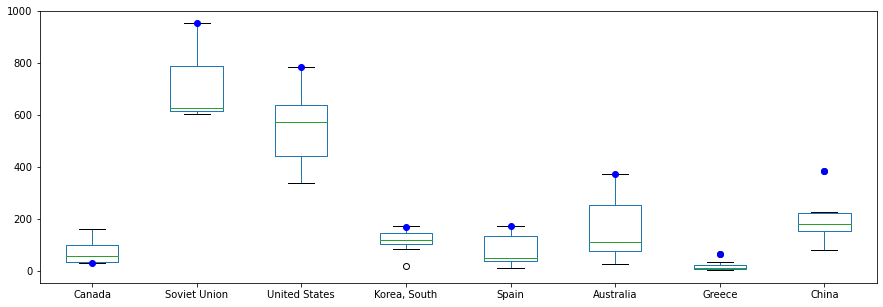

In [21]:
x = ['Canada', 'Soviet Union', 'United States', 'Korea, South', 'Spain',
       'Australia', 'Greece', 'China']
y = [28,953,784,170,174,372,65,385]

frame_pt[frame_pt.columns[:-1]].plot(kind='box',figsize=(15,5));
plt.plot([1,2,3,4,5,6,7,8],y,'bo');

In [22]:
frame.columns

Index(['Canada', 'Soviet Union', 'United States', 'Korea, South', 'Spain',
       'Australia', 'Greece', 'China'],
      dtype='object')

In [23]:
frame

,Canada,Soviet Union,United States,"Korea, South",Spain,Australia,Greece,China
1976.0,28.0,604.0,337.0,20.0,12.0,40.0,NaN,NaN
1980.0,NaN,953.0,NaN,NaN,47.0,24.0,7.0,NaN
1984.0,159.0,NaN,784.0,83.0,37.0,78.0,3.0,141.0
1988.0,34.0,627.0,411.0,170.0,9.0,76.0,1.0,81.0
1992.0,103.0,NaN,452.0,110.0,174.0,112.0,6.0,165.0
1996.0,98.0,NaN,628.0,135.0,136.0,212.0,20.0,222.0
2000.0,43.0,NaN,574.0,123.0,69.0,372.0,32.0,180.0
2004.0,33.0,NaN,571.0,108.0,50.0,333.0,65.0,225.0
2008.0,69.0,NaN,674.0,171.0,133.0,253.0,10.0,385.0


In [24]:
frame

,Canada,Soviet Union,United States,"Korea, South",Spain,Australia,Greece,China
1976.0,28.0,604.0,337.0,20.0,12.0,40.0,NaN,NaN
1980.0,NaN,953.0,NaN,NaN,47.0,24.0,7.0,NaN
1984.0,159.0,NaN,784.0,83.0,37.0,78.0,3.0,141.0
1988.0,34.0,627.0,411.0,170.0,9.0,76.0,1.0,81.0
1992.0,103.0,NaN,452.0,110.0,174.0,112.0,6.0,165.0
1996.0,98.0,NaN,628.0,135.0,136.0,212.0,20.0,222.0
2000.0,43.0,NaN,574.0,123.0,69.0,372.0,32.0,180.0
2004.0,33.0,NaN,571.0,108.0,50.0,333.0,65.0,225.0
2008.0,69.0,NaN,674.0,171.0,133.0,253.0,10.0,385.0


In [25]:
sov_union = olympics_data[olympics_data['Country']=='Soviet Union'].groupby('Year').sum()
russia = olympics_data[olympics_data['Country']=='Russia'].groupby('Year').sum()
unif_team = olympics_data[olympics_data['Country']=='Unified team'].groupby('Year').sum()

sov_union_russia = sov_union.append(russia)
sov_union_russia = sov_union_russia.append(unif_team)
sov_union_russia = sov_union_russia.sort_index()

In [26]:
x = 0
l = sov_union_russia['Points'].values
sov_rus_pts = []

for i in range(2):
    sov_rus_pts.append(float(l[i]))
sov_rus_pts.append(np.nan)
for i in range(2,8):
    sov_rus_pts.append(float(l[i]))
sov_rus_pts


[604.0, 953.0, nan, 627.0, 472.0, 232.0, 388.0, 335.0, 273.0]

In [27]:
frame['Soviet Union/Russia'] = sov_rus_pts

In [28]:
frame = frame[['Canada', 'Soviet Union/Russia', 'United States', 'Korea, South', 'Spain',
       'Australia', 'Greece', 'China']]

In [29]:
frame

,Canada,Soviet Union/Russia,United States,"Korea, South",Spain,Australia,Greece,China
1976.0,28.0,604.0,337.0,20.0,12.0,40.0,NaN,NaN
1980.0,NaN,953.0,NaN,NaN,47.0,24.0,7.0,NaN
1984.0,159.0,NaN,784.0,83.0,37.0,78.0,3.0,141.0
1988.0,34.0,627.0,411.0,170.0,9.0,76.0,1.0,81.0
1992.0,103.0,472.0,452.0,110.0,174.0,112.0,6.0,165.0
1996.0,98.0,232.0,628.0,135.0,136.0,212.0,20.0,222.0
2000.0,43.0,388.0,574.0,123.0,69.0,372.0,32.0,180.0
2004.0,33.0,335.0,571.0,108.0,50.0,333.0,65.0,225.0
2008.0,69.0,273.0,674.0,171.0,133.0,253.0,10.0,385.0


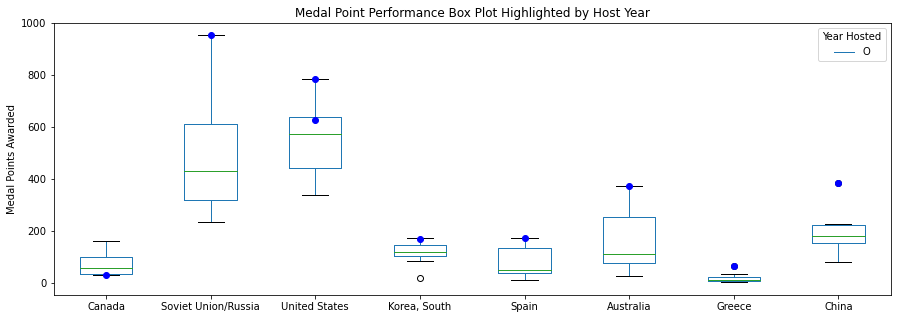

In [30]:
x = ['Canada', 'Soviet Union/Russia', 'United States', 'Korea, South', 'Spain',
       'Australia', 'Greece', 'China']
y = [28,953,784,628,170,174,372,65,385]

frame[frame.columns].plot(kind='box',figsize=(15,5))
plt.title('Medal Point Performance Box Plot Highlighted by Host Year')
plt.ylabel('Medal Points Awarded')
# plt.xlabel('Host Countries from 1976 - 2008')
plt.plot([1,2,3,3,4,5,6,7,8],y,'bo');

plt.legend(labels='O'[0],title='Year Hosted');


In [31]:
frame

,Canada,Soviet Union/Russia,United States,"Korea, South",Spain,Australia,Greece,China
1976.0,28.0,604.0,337.0,20.0,12.0,40.0,NaN,NaN
1980.0,NaN,953.0,NaN,NaN,47.0,24.0,7.0,NaN
1984.0,159.0,NaN,784.0,83.0,37.0,78.0,3.0,141.0
1988.0,34.0,627.0,411.0,170.0,9.0,76.0,1.0,81.0
1992.0,103.0,472.0,452.0,110.0,174.0,112.0,6.0,165.0
1996.0,98.0,232.0,628.0,135.0,136.0,212.0,20.0,222.0
2000.0,43.0,388.0,574.0,123.0,69.0,372.0,32.0,180.0
2004.0,33.0,335.0,571.0,108.0,50.0,333.0,65.0,225.0
2008.0,69.0,273.0,674.0,171.0,133.0,253.0,10.0,385.0


In [32]:
frame.columns

Index(['Canada', 'Soviet Union/Russia', 'United States', 'Korea, South',
       'Spain', 'Australia', 'Greece', 'China'],
      dtype='object')

In [33]:
frame[frame.columns]

,Canada,Soviet Union/Russia,United States,"Korea, South",Spain,Australia,Greece,China
1976.0,28.0,604.0,337.0,20.0,12.0,40.0,NaN,NaN
1980.0,NaN,953.0,NaN,NaN,47.0,24.0,7.0,NaN
1984.0,159.0,NaN,784.0,83.0,37.0,78.0,3.0,141.0
1988.0,34.0,627.0,411.0,170.0,9.0,76.0,1.0,81.0
1992.0,103.0,472.0,452.0,110.0,174.0,112.0,6.0,165.0
1996.0,98.0,232.0,628.0,135.0,136.0,212.0,20.0,222.0
2000.0,43.0,388.0,574.0,123.0,69.0,372.0,32.0,180.0
2004.0,33.0,335.0,571.0,108.0,50.0,333.0,65.0,225.0
2008.0,69.0,273.0,674.0,171.0,133.0,253.0,10.0,385.0


In [34]:
frame['Canada'].mean()

70.875

In [35]:
frame.columns

Index(['Canada', 'Soviet Union/Russia', 'United States', 'Korea, South',
       'Spain', 'Australia', 'Greece', 'China'],
      dtype='object')

In [36]:
new_dict = {'Canada':[], 'Soviet Union/Russia':[], 'United States':[], 'Korea, South':[], 'Spain':[],
       'Australia':[], 'Greece':[], 'China':[]}

for col in frame.columns:
    avg = frame[col].mean()
    for line in frame[col]:
        new_dict[col].append(line/avg)
new_dict

{'Canada': [0.3950617283950617,
  nan,
  2.2433862433862433,
  0.47971781305114636,
  1.4532627865961198,
  1.382716049382716,
  0.6067019400352733,
  0.4656084656084656,
  0.9735449735449735],
 'Soviet Union/Russia': [1.2440782698249229,
  1.9629248197734295,
  nan,
  1.2914521112255406,
  0.972193614830072,
  0.47785787847579814,
  0.7991761071060762,
  0.690010298661174,
  0.5623069001029866],
 'United States': [0.6084405326111487,
  nan,
  1.415481832543444,
  0.7420446851726472,
  0.8160686075378019,
  1.1338298352516363,
  1.0363349131121642,
  1.0309185285488602,
  1.2168810652222974],
 'Korea, South': [0.17391304347826086,
  nan,
  0.7217391304347827,
  1.4782608695652173,
  0.9565217391304348,
  1.173913043478261,
  1.0695652173913044,
  0.9391304347826087,
  1.4869565217391305],
 'Spain': [0.1619190404797601,
  0.6341829085457271,
  0.49925037481259366,
  0.12143928035982009,
  2.3478260869565215,
  1.8350824587706147,
  0.9310344827586207,
  0.6746626686656672,
  1.794602698

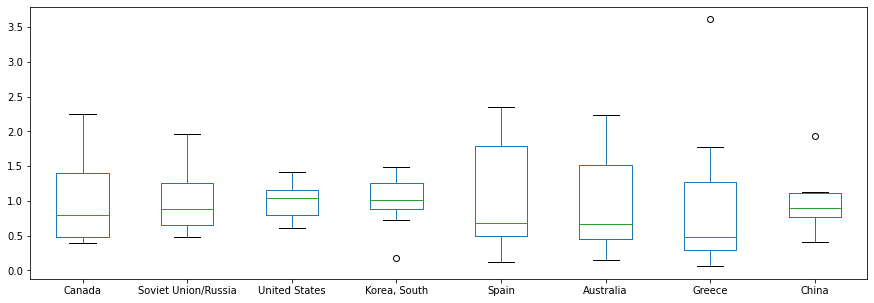

In [37]:
pd.DataFrame(new_dict).plot(kind='box',figsize=(15,5))

In [38]:
host_year = {1976:'Canada',1980:'Soviet Union/Russia',1984:'United States',1988:'Korea, South',1992:'Spain',1996:'United States',
             2000:'Australia',2004:'Greece', 2008:'China'}

for country in ['Canada', 'Soviet Union/Russia', 'United States', 'Korea, South',
       'Spain', 'Australia', 'Greece', 'China']:
    frame[country]
frame
    

,Canada,Soviet Union/Russia,United States,"Korea, South",Spain,Australia,Greece,China
1976.0,28.0,604.0,337.0,20.0,12.0,40.0,NaN,NaN
1980.0,NaN,953.0,NaN,NaN,47.0,24.0,7.0,NaN
1984.0,159.0,NaN,784.0,83.0,37.0,78.0,3.0,141.0
1988.0,34.0,627.0,411.0,170.0,9.0,76.0,1.0,81.0
1992.0,103.0,472.0,452.0,110.0,174.0,112.0,6.0,165.0
1996.0,98.0,232.0,628.0,135.0,136.0,212.0,20.0,222.0
2000.0,43.0,388.0,574.0,123.0,69.0,372.0,32.0,180.0
2004.0,33.0,335.0,571.0,108.0,50.0,333.0,65.0,225.0
2008.0,69.0,273.0,674.0,171.0,133.0,253.0,10.0,385.0


In [39]:
frame['Canada'].loc(0)

In [40]:
frame['Canada'][0:]

1976.0     28.0
1980.0      NaN
1984.0    159.0
1988.0     34.0
1992.0    103.0
1996.0     98.0
2000.0     43.0
2004.0     33.0
2008.0     69.0
Name: Canada, dtype: float64

In [41]:
frame.columns

Index(['Canada', 'Soviet Union/Russia', 'United States', 'Korea, South',
       'Spain', 'Australia', 'Greece', 'China'],
      dtype='object')

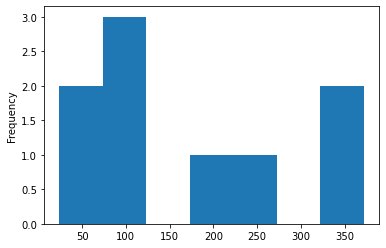

In [44]:
frame['Australia'].plot(kind='hist',bins=7)